In [ ]:
##############################################################################################################

In [2]:
import pandas as pd

# CSV 파일 불러오기
df = pd.read_csv("../1stProject/data/목적별_국적별_입국.csv", encoding='cp949')

# "소 계" 포함된 행 제거
df_cleaned = df[~df.apply(lambda row: row.astype(str).str.contains("소 계").any(), axis=1)]

# 결과 저장
df_cleaned.to_csv("../1stProject/data/목적별_국적별_입국_소계제거.csv", index=False, encoding='cp949')

FileNotFoundError: [Errno 2] No such file or directory: '../1stProject/data/목적별_국적별_입국.csv'

In [ ]:
import pandas as pd

df = pd.read_excel("../1stProject/data/목적별 국적별 입국_250709084025.xls", engine="xlrd")
df.to_csv("../1stProject/data/목적별_국적별_입국.csv", index=False, encoding="cp949")


In [5]:
import pandas as pd
import numpy as np
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import platform

# [1] 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')
else:
    plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

# [2] 데이터 로딩 및 전처리
df = pd.read_csv('../1stProject/data/목적별_국적별_입국_소계제거.csv', encoding='cp949')
df = df.melt(id_vars=["국적", "목적"], var_name="월", value_name="입국자수")

# ⛔️ "입국자수"에 숫자가 아닌 값 필터링 제거
df = df[~df["입국자수"].str.contains("명|합계|소계|인원", na=False)]

# 날짜 및 수치형 변환
df["월"] = pd.to_datetime(df["월"], format="%Y년%m월")
df["입국자수"] = df["입국자수"].astype(str).str.replace(",", "").astype(float)

# 관광 목적만 필터링
df = df[df["목적"] == "관광"].sort_values("월").reset_index(drop=True)

# [3] Prophet용 데이터
df_prophet = df.groupby("월")["입국자수"].sum().reset_index()
df_prophet.columns = ["ds", "y"]

# [4] Prophet 모델 훈련 및 예측
prophet = Prophet(yearly_seasonality=True)
prophet.fit(df_prophet)
future = prophet.make_future_dataframe(periods=6, freq='MS')
forecast = prophet.predict(future)

# [5] XGBoost용 피처 생성
df_feat = df_prophet.copy()
df_feat["연도"] = df_feat["ds"].dt.year
df_feat["월"] = df_feat["ds"].dt.month
df_feat["계절"] = df_feat["월"] % 12 // 3
df_feat["전월입국자수"] = df_feat["y"].shift(1)
df_feat["전년동월입국자수"] = df_feat["y"].shift(12)
df_feat["전월증감률"] = df_feat["y"].pct_change().shift(1)
df_feat["전년증감률"] = (df_feat["y"] - df_feat["y"].shift(12)) / df_feat["y"].shift(12)
df_feat["이동평균"] = df_feat["y"].rolling(window=3).mean().shift(1)
df_feat = df_feat.replace([np.inf, -np.inf], np.nan).dropna()

# [6] XGBoost 모델 학습 및 예측
features = ["연도", "월", "계절", "전월입국자수", "전년동월입국자수", "전월증감률", "전년증감률", "이동평균"]
X = df_feat[features]
y = df_feat["y"]
X_train, X_test = X[:-6], X[-6:]
y_train, y_test = y[:-6], y[-6:]

model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=4, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred = np.clip(y_pred, 0, None)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# [7] 시각화
plt.figure(figsize=(14, 6))
plt.plot(df_feat["ds"], df_feat["y"], label="실제 입국자수", color='blue')
plt.plot(forecast["ds"], forecast["yhat"], label="Prophet 예측", color='green', linestyle='--')
plt.plot(df_feat["ds"].iloc[-6:], y_pred, label="XGBoost 예측", color='orange', marker='o')
plt.axvline(df_feat["ds"].iloc[-7], color='gray', linestyle='--', label="예측 시작")
plt.title(f"입국자 수 예측 (Prophet + XGBoost 병렬)\nXGBoost RMSE: {rmse:.0f}")
plt.xlabel("월")
plt.ylabel("입국자 수")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


✅ 사용 가능한 국적 목록:


TypeError: '<' not supported between instances of 'str' and 'float'

In [3]:
# %pip install prophet xgboost

  Using cached prophet-1.1.7-py3-none-win_amd64.whl.metadata (3.6 kB)
  Using cached cmdstanpy-1.2.5-py3-none-any.whl.metadata (4.0 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached importlib_resources-6.5.2-py3-none-any.whl.metadata (3.9 kB)
  Using cached stanio-0.5.1-py3-none-any.whl.metadata (1.6 kB)
Using cached prophet-1.1.7-py3-none-win_amd64.whl (13.3 MB)
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 1.1/1.1 MB 9.2 MB/s eta 0:00:00
Using cached cmdstanpy-1.2.5-py3-none-any.whl (94 kB)
Using cached stanio-0.5.1-py3-none-any.whl (8.1 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Using cached importlib_resources-6.5.2-py3-none-any.whl (37 kB)

   ---------------------------------------- 0/6 [tqdm]
   ------------- -------------------------- 2/6 [importlib_resources]
   ------------- -------------------------- 2/6 [importlib_resources]
   -------------------- -------------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [3]:
# GPU 이용
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from matplotlib import rcParams

plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows 한글 폰트
plt.rcParams['axes.unicode_minus'] = False     # 음수 기호 깨짐 방지

# 문자열 정규화 함수
def normalize(text):
    return text.replace(" ", "").lower()

# [1] 사용자 입력 및 유사 매칭
선택_국적 = input("예측할 국적 입력 (전체 예측 원하면 Enter): ").strip()
선택_목적 = input("예측할 목적 입력 (전체 예측 원하면 Enter): ").strip()

# [2] 데이터 로딩 및 전처리
df = pd.read_csv('../1stProject/data/목적별_국적별_입국_소계제거.csv', encoding='cp949')
df = df.melt(id_vars=["국적", "목적"], var_name="월", value_name="입국자수")
df["월"] = pd.to_datetime(df["월"], format="%Y년%m월")
df["입국자수"] = pd.to_numeric(df["입국자수"].astype(str).str.replace(",", "", regex=False), errors="coerce")

# [3] 유사 국적/목적 자동 완성
if 선택_국적:
    match = [nat for nat in df["국적"].dropna().unique()
             if isinstance(nat, str) and normalize(선택_국적) in normalize(nat)]
    if match:
        선택_국적 = match[0]
        print(f"👉 입력한 국적과 유사한 값으로 '{선택_국적}' 사용")
    else:
        print("❌ 유효한 국적이 아닙니다."); 선택_국적 = ""

if 선택_목적:
    match = [pur for pur in df["목적"].dropna().unique()
             if isinstance(pur, str) and normalize(선택_목적) in normalize(pur)]
    if match:
        선택_목적 = match[0]
        print(f"👉 입력한 목적과 유사한 값으로 '{선택_목적}' 사용")
    else:
        print("❌ 유효한 목적이 아닙니다."); 선택_목적 = ""

# [4] 예측 대상 필터링
targets = df.groupby(["국적", "목적"]).size().reset_index().rename(columns={0: "count"})
valid_targets = targets[targets['count'] > 24]
if 선택_국적:
    valid_targets = valid_targets[valid_targets["국적"] == 선택_국적]
if 선택_목적:
    valid_targets = valid_targets[valid_targets["목적"] == 선택_목적]

# [5] 예측 루프
for idx, row in valid_targets.iterrows():
    국적, 목적 = row["국적"], row["목적"]
    df_filtered = df[(df["국적"] == 국적) & (df["목적"] == 목적)].sort_values("월").reset_index(drop=True)

    if len(df_filtered) < 30:
        continue
    print(f"\n📌 예측 대상: {국적} / {목적} ({len(df_filtered)} 개월치)")

    # 파생 변수 생성
    df_filtered["연도"] = df_filtered["월"].dt.year
    df_filtered["월_숫자"] = df_filtered["월"].dt.month
    df_filtered["계절"] = df_filtered["월"].dt.month % 12 // 3
    df_filtered["전월입국자수"] = df_filtered["입국자수"].shift(1)
    df_filtered["전년동월입국자수"] = df_filtered["입국자수"].shift(12)
    df_filtered["전월증감률"] = df_filtered["입국자수"].pct_change().shift(1)
    df_filtered["전년증감률"] = (df_filtered["입국자수"] - df_filtered["입국자수"].shift(12)) / df_filtered["입국자수"].shift(12)
    df_filtered["이동평균3"] = df_filtered["입국자수"].rolling(window=3).mean().shift(1)
    df_filtered["이동평균6"] = df_filtered["입국자수"].rolling(window=6).mean().shift(1)
    df_filtered["전월_차이"] = df_filtered["입국자수"] - df_filtered["전월입국자수"]
    df_filtered["전년_차이"] = df_filtered["입국자수"] - df_filtered["전년동월입국자수"]
    df_filtered["연중누적합"] = df_filtered.groupby("연도")["입국자수"].cumsum()
    df_filtered = df_filtered.replace([np.inf, -np.inf], np.nan).dropna().copy()

    if df_filtered.empty:
        continue

    # 특징 및 타겟
    features = ["연도", "월_숫자", "계절", "전월입국자수", "전년동월입국자수",
                "전월증감률", "전년증감률", "이동평균3", "이동평균6",
                "전월_차이", "전년_차이", "연중누적합"]
    X = df_filtered[features]
    y = df_filtered["입국자수"]
    dates = df_filtered["월"]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 학습/테스트 분리
    X_train, X_test = X_scaled[:-6], X_scaled[-6:]
    y_train, y_test = y[:-6], y[-6:]
    dates_train, dates_test = dates[:-6], dates[-6:]

    if len(X_test) == 0:
        continue

    # GPU XGBoost 모델 및 튜닝
    xgb = XGBRegressor(tree_method='gpu_hist', predictor='gpu_predictor', gpu_id=0, random_state=42)
    param_dist = {
        'n_estimators': [100, 300, 500],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    }
    search = RandomizedSearchCV(xgb, param_distributions=param_dist, n_iter=10,
                                 cv=TimeSeriesSplit(n_splits=3),
                                 scoring='neg_root_mean_squared_error', random_state=42)
    search.fit(X_train, y_train)
    best_model = search.best_estimator_

    y_pred = np.clip(best_model.predict(X_test), 0, None)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100

    # 시각화
    plt.figure(figsize=(14, 6))
    plt.plot(dates_train, y_train, label="실제값 (학습)", color='blue')
    plt.plot(dates_test, y_test, label="실제값 (테스트)", color='red', linestyle='--')
    plt.plot(dates_test, y_pred, label="예측값 (XGBoost)", color='orange', marker='o')
    plt.title(f"📊 {국적}/{목적} - RMSE: {rmse:.0f}, MAPE: {mape:.1f}%")
    plt.xlabel("월")
    plt.ylabel("입국자 수")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Prophet 시계열 예측
    df_prophet = df_filtered[["월", "입국자수"]].rename(columns={"월": "ds", "입국자수": "y"})
    prophet = Prophet(yearly_seasonality=True)
    try:
        prophet.add_country_holidays(country_name='KR')
        prophet.fit(df_prophet)
        future = prophet.make_future_dataframe(periods=6, freq='MS')
        forecast = prophet.predict(future)

        plt.figure(figsize=(14, 5))
        plt.plot(df_prophet['ds'], df_prophet['y'], label='실제값')
        plt.plot(forecast['ds'], forecast['yhat'], label='예측값 (Prophet)', color='green')
        plt.title(f"🔮 Prophet 예측 - {국적}/{목적}")
        plt.xlabel("월")
        plt.ylabel("입국자 수")
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"[Prophet 오류] {국적}/{목적}: {e}")


예측할 국적 입력 (전체 예측 원하면 Enter): 일본
예측할 목적 입력 (전체 예측 원하면 Enter): 관광
👉 입력한 국적과 유사한 값으로 '일  본' 사용
👉 입력한 목적과 유사한 값으로 '관광' 사용

📌 예측 대상: 일  본 / 관광 (92 개월치)


ValueError: 
All the 30 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\envs\project\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Admin\anaconda3\envs\project\lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
  File "C:\Users\Admin\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py", line 1247, in fit
    self._Booster = train(
  File "C:\Users\Admin\anaconda3\envs\project\lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
  File "C:\Users\Admin\anaconda3\envs\project\lib\site-packages\xgboost\training.py", line 183, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "C:\Users\Admin\anaconda3\envs\project\lib\site-packages\xgboost\core.py", line 2246, in update
    _check_call(
  File "C:\Users\Admin\anaconda3\envs\project\lib\site-packages\xgboost\core.py", line 310, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [10:14:54] C:\actions-runner\_work\xgboost\xgboost\src\tree\updater_gpu_hist.cu:847: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


In [11]:
# CPU 이용
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from matplotlib import rcParams

plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows 한글 폰트
plt.rcParams['axes.unicode_minus'] = False     # 음수 기호 깨짐 방지

# 문자열 정규화 함수
def normalize(text):
    return text.replace(" ", "").lower()

# [1] 사용자 입력 및 유사 매칭
선택_국적 = input("예측할 국적 입력 (전체 예측 원하면 Enter): ").strip()
선택_목적 = input("예측할 목적 입력 (전체 예측 원하면 Enter): ").strip()

# [2] 데이터 로딩 및 전처리
df = pd.read_csv('../1stProject/data/목적별_국적별_입국_(05년1월~25년5월).csv', encoding='cp949')
df = df.melt(id_vars=["국적", "목적"], var_name="월", value_name="입국자수")
df["월"] = pd.to_datetime(df["월"], format="%Y년%m월")
df["입국자수"] = pd.to_numeric(df["입국자수"].astype(str).str.replace(",", "", regex=False), errors="coerce")

# [3] 유사 국적/목적 자동 완성
if 선택_국적:
    match = [nat for nat in df["국적"].dropna().unique()
             if isinstance(nat, str) and normalize(선택_국적) in normalize(nat)]
    if match:
        선택_국적 = match[0]
        print(f"👉 입력한 국적과 유사한 값으로 '{선택_국적}' 사용")
    else:
        print("❌ 유효한 국적이 아닙니다."); 선택_국적 = ""

if 선택_목적:
    match = [pur for pur in df["목적"].dropna().unique()
             if isinstance(pur, str) and normalize(선택_목적) in normalize(pur)]
    if match:
        선택_목적 = match[0]
        print(f"👉 입력한 목적과 유사한 값으로 '{선택_목적}' 사용")
    else:
        print("❌ 유효한 목적이 아닙니다."); 선택_목적 = ""

# [4] 예측 대상 필터링
targets = df.groupby(["국적", "목적"]).size().reset_index().rename(columns={0: "count"})
valid_targets = targets[targets['count'] > 24]
if 선택_국적:
    valid_targets = valid_targets[valid_targets["국적"] == 선택_국적]
if 선택_목적:
    valid_targets = valid_targets[valid_targets["목적"] == 선택_목적]

# [5] 예측 루프
for idx, row in valid_targets.iterrows():
    국적, 목적 = row["국적"], row["목적"]
    df_filtered = df[(df["국적"] == 국적) & (df["목적"] == 목적)].sort_values("월").reset_index(drop=True)

    if len(df_filtered) < 30:
        continue
    print(f"\n📌 예측 대상: {국적} / {목적} ({len(df_filtered)} 개월치)")

    # 파생 변수 생성
    df_filtered["연도"] = df_filtered["월"].dt.year
    df_filtered["월_숫자"] = df_filtered["월"].dt.month
    df_filtered["계절"] = df_filtered["월"].dt.month % 12 // 3
    df_filtered["전월입국자수"] = df_filtered["입국자수"].shift(1)
    df_filtered["전년동월입국자수"] = df_filtered["입국자수"].shift(12)
    df_filtered["전월증감률"] = df_filtered["입국자수"].pct_change().shift(1)
    df_filtered["전년증감률"] = (df_filtered["입국자수"] - df_filtered["입국자수"].shift(12)) / df_filtered["입국자수"].shift(12)
    df_filtered["이동평균3"] = df_filtered["입국자수"].rolling(window=3).mean().shift(1)
    df_filtered["이동평균6"] = df_filtered["입국자수"].rolling(window=6).mean().shift(1)
    df_filtered["전월_차이"] = df_filtered["입국자수"] - df_filtered["전월입국자수"]
    df_filtered["전년_차이"] = df_filtered["입국자수"] - df_filtered["전년동월입국자수"]
    df_filtered["연중누적합"] = df_filtered.groupby("연도")["입국자수"].cumsum()
    df_filtered = df_filtered.replace([np.inf, -np.inf], np.nan).dropna().copy()

    if df_filtered.empty:
        continue

    # 특징 및 타겟
    features = ["연도", "월_숫자", "계절", "전월입국자수", "전년동월입국자수",
                "전월증감률", "전년증감률", "이동평균3", "이동평균6",
                "전월_차이", "전년_차이", "연중누적합"]
    X = df_filtered[features]
    y = df_filtered["입국자수"]
    dates = df_filtered["월"]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 학습/테스트 분리
    X_train, X_test = X_scaled[:-6], X_scaled[-6:]
    y_train, y_test = y[:-6], y[-6:]
    dates_train, dates_test = dates[:-6], dates[-6:]

    if len(X_test) == 0:
        continue

    # CPU 기반 XGBoost 모델
    xgb = XGBRegressor(random_state=42)
    param_dist = {
        'n_estimators': [100, 300, 500],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    }
    search = RandomizedSearchCV(xgb, param_distributions=param_dist, n_iter=10,
                                 cv=TimeSeriesSplit(n_splits=3),
                                 scoring='neg_root_mean_squared_error', random_state=42)
    search.fit(X_train, y_train)
    best_model = search.best_estimator_

    y_pred = np.clip(best_model.predict(X_test), 0, None)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100

    # 시각화
    plt.figure(figsize=(14, 6))
    plt.plot(dates_train, y_train, label="실제값 (학습)", color='blue')
    plt.plot(dates_test, y_test, label="실제값 (테스트)", color='red', linestyle='--')
    plt.plot(dates_test, y_pred, label="예측값 (XGBoost)", color='orange', marker='o')
    plt.title(f"📊 {국적}/{목적} - RMSE: {rmse:.0f}, MAPE: {mape:.1f}%")
    plt.xlabel("월")
    plt.ylabel("입국자 수")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Prophet 시계열 예측
    df_prophet = df_filtered[["월", "입국자수"]].rename(columns={"월": "ds", "입국자수": "y"})
    prophet = Prophet(yearly_seasonality=True)
    try:
        prophet.add_country_holidays(country_name='KR')
        prophet.fit(df_prophet)
        future = prophet.make_future_dataframe(periods=6, freq='MS')
        forecast = prophet.predict(future)

        plt.figure(figsize=(14, 5))
        plt.plot(df_prophet['ds'], df_prophet['y'], label='실제값')
        plt.plot(forecast['ds'], forecast['yhat'], label='예측값 (Prophet)', color='green')
        plt.title(f"🔮 Prophet 예측 - {국적}/{목적}")
        plt.xlabel("월")
        plt.ylabel("입국자 수")
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"[Prophet 오류] {국적}/{목적}: {e}")


예측할 국적 입력 (전체 예측 원하면 Enter): 일본
예측할 목적 입력 (전체 예측 원하면 Enter): 관광


ValueError: time data '계' does not match format '%Y년%m월' (match)

예측할 국적 입력 (전체 예측 원하면 Enter): 대만
예측할 목적 입력 (전체 예측 원하면 Enter): 
👉 입력한 국적과 유사한 값으로 '대  만' 사용

📌 예측 대상: 대  만 / 공용 (245 개월치)

📊 XGBoost 성능 평가
- RMSE: 2
- MAPE: 8.7%
- 평균 대비 RMSE 비율: 11.0%
✅ 매우 우수한 예측 (MAPE < 10%)
           월   실제값  예측값  오차  오차율(%)
239  2024-12   9.0    8   0   -6.24
240  2025-01  25.0   25   0    3.56
241  2025-02  14.0   11  -2  -20.15
242  2025-03  21.0   18  -2  -12.39
243  2025-04  11.0   10   0   -5.75
244  2025-05  10.0   10   0    4.28


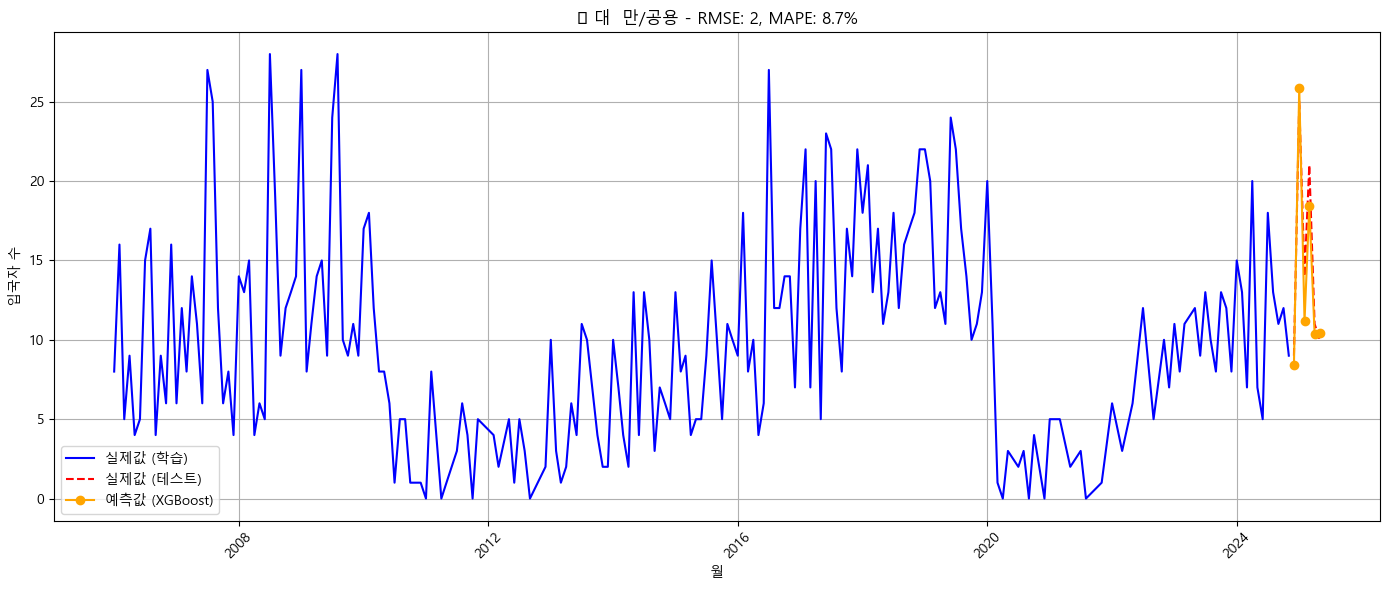

16:54:28 - cmdstanpy - INFO - Chain [1] start processing
16:54:28 - cmdstanpy - INFO - Chain [1] done processing


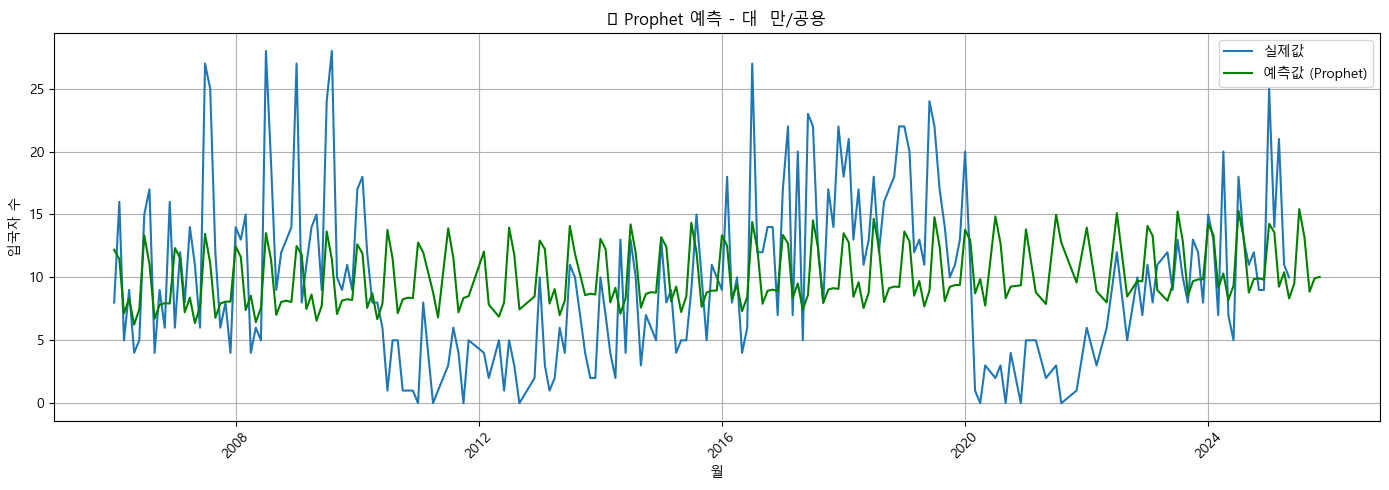


📌 예측 대상: 대  만 / 관광 (245 개월치)

📊 XGBoost 성능 평가
- RMSE: 9270
- MAPE: 6.1%
- 평균 대비 RMSE 비율: 6.9%
✅ 매우 우수한 예측 (MAPE < 10%)
           월       실제값     예측값     오차  오차율(%)
239  2024-12  117549.0  115948  -1600   -1.36
240  2025-01  134439.0  123498 -10940   -8.14
241  2025-02  117995.0  109551  -8443   -7.16
242  2025-03  138666.0  132022  -6643   -4.79
243  2025-04  150603.0  136694 -13908   -9.24
244  2025-05  148871.0  139677  -9193   -6.18


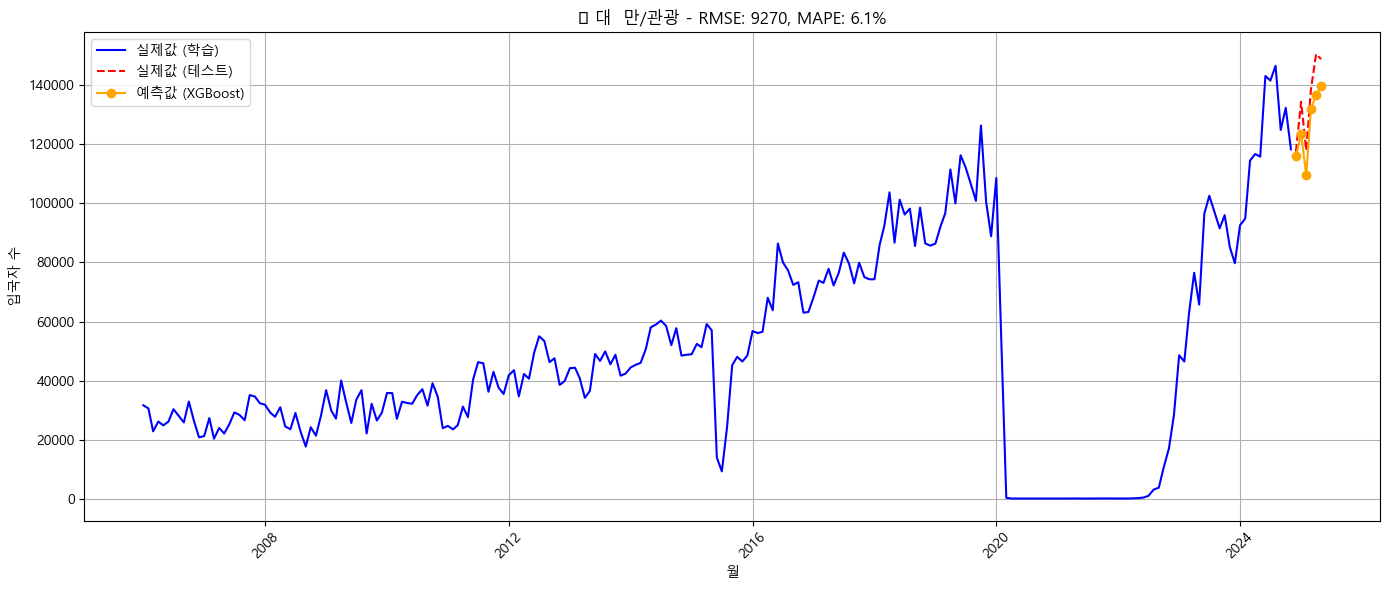

16:54:36 - cmdstanpy - INFO - Chain [1] start processing
16:54:37 - cmdstanpy - INFO - Chain [1] done processing


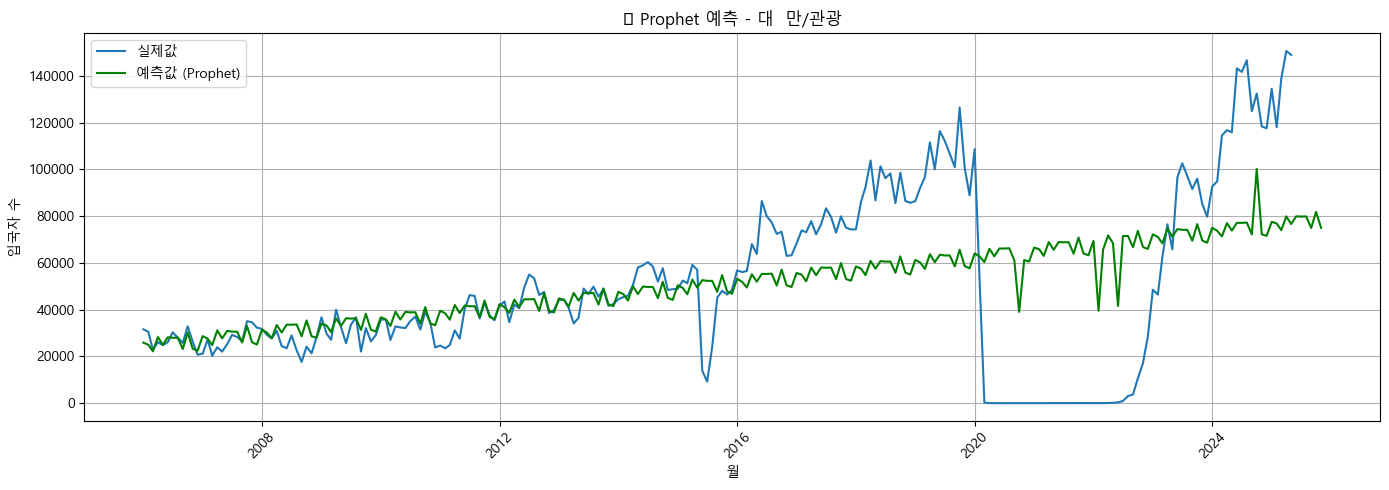


📌 예측 대상: 대  만 / 기타 (245 개월치)

📊 XGBoost 성능 평가
- RMSE: 21
- MAPE: 2.6%
- 평균 대비 RMSE 비율: 2.8%
✅ 매우 우수한 예측 (MAPE < 10%)
           월    실제값  예측값  오차  오차율(%)
239  2024-12  680.0  668 -11   -1.67
240  2025-01  680.0  708  28    4.15
241  2025-02  778.0  767 -10   -1.30
242  2025-03  719.0  698 -20   -2.81
243  2025-04  686.0  717  31    4.54
244  2025-05  802.0  790 -11   -1.42


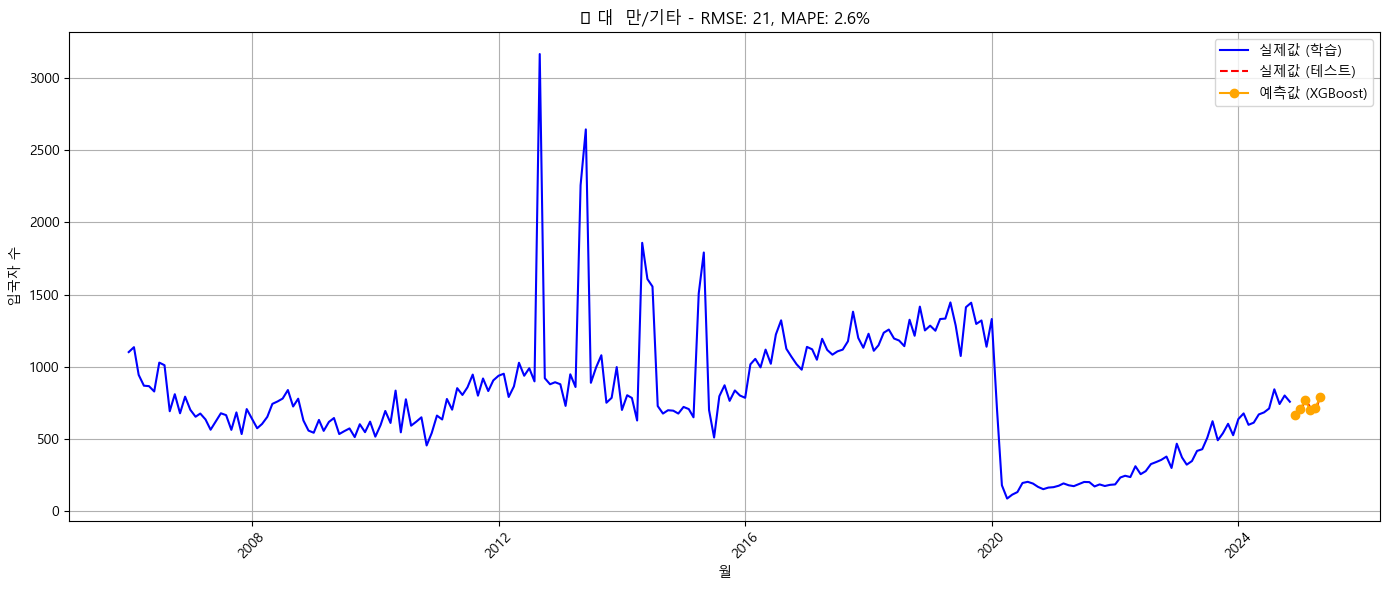

16:54:47 - cmdstanpy - INFO - Chain [1] start processing
16:54:47 - cmdstanpy - INFO - Chain [1] done processing


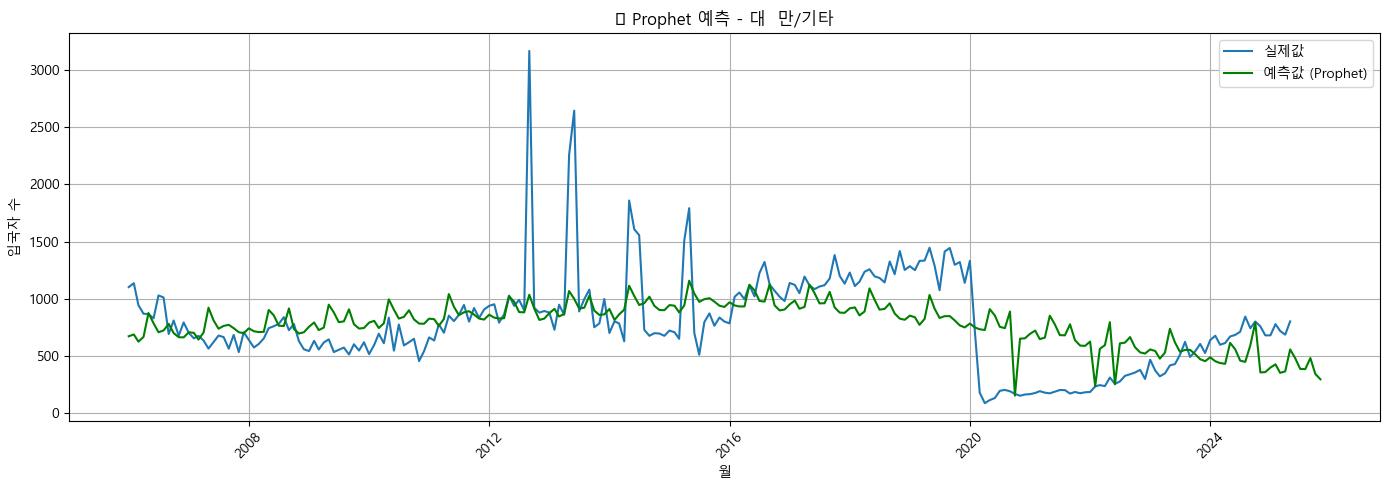


📌 예측 대상: 대  만 / 상용 (245 개월치)

📊 XGBoost 성능 평가
- RMSE: 3
- MAPE: 2.4%
- 평균 대비 RMSE 비율: 4.2%
✅ 매우 우수한 예측 (MAPE < 10%)
           월    실제값  예측값  오차  오차율(%)
239  2024-12   78.0   77   0   -0.07
240  2025-01   63.0   61  -1   -1.61
241  2025-02   89.0   89   0    0.46
242  2025-03   82.0   82   0    0.06
243  2025-04  100.0   95  -4   -4.30
244  2025-05   90.0   82  -7   -8.10


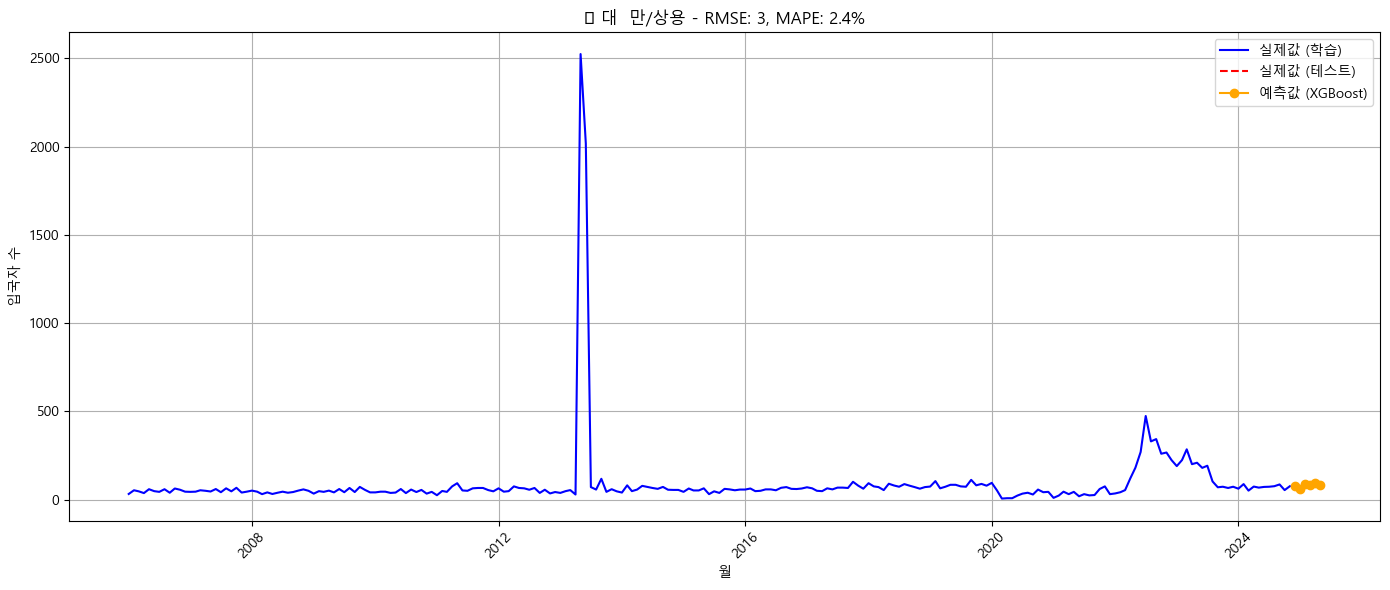

16:54:55 - cmdstanpy - INFO - Chain [1] start processing
16:54:55 - cmdstanpy - INFO - Chain [1] done processing


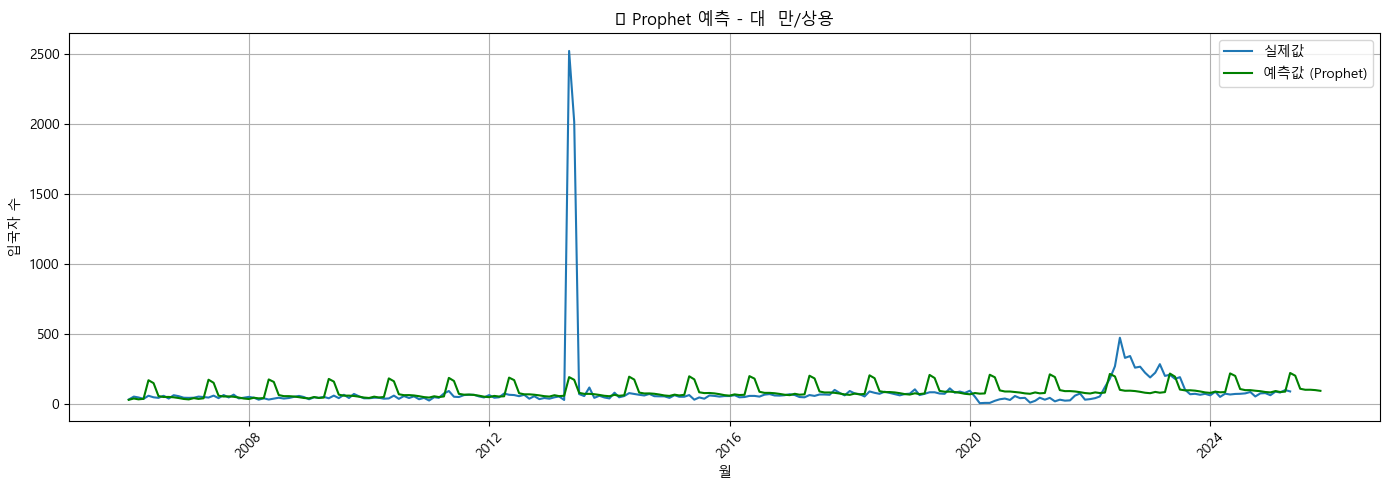


📌 예측 대상: 대  만 / 소 계 (245 개월치)

📊 XGBoost 성능 평가
- RMSE: 5939
- MAPE: 3.1%
- 평균 대비 RMSE 비율: 4.4%
✅ 매우 우수한 예측 (MAPE < 10%)
           월       실제값     예측값    오차  오차율(%)
239  2024-12  118696.0  118508  -187   -0.16
240  2025-01  135434.0  131192 -4241   -3.13
241  2025-02  120015.0  120838   823    0.69
242  2025-03  140017.0  137686 -2330   -1.66
243  2025-04  151613.0  141764 -9848   -6.50
244  2025-05  150272.0  140760 -9511   -6.33


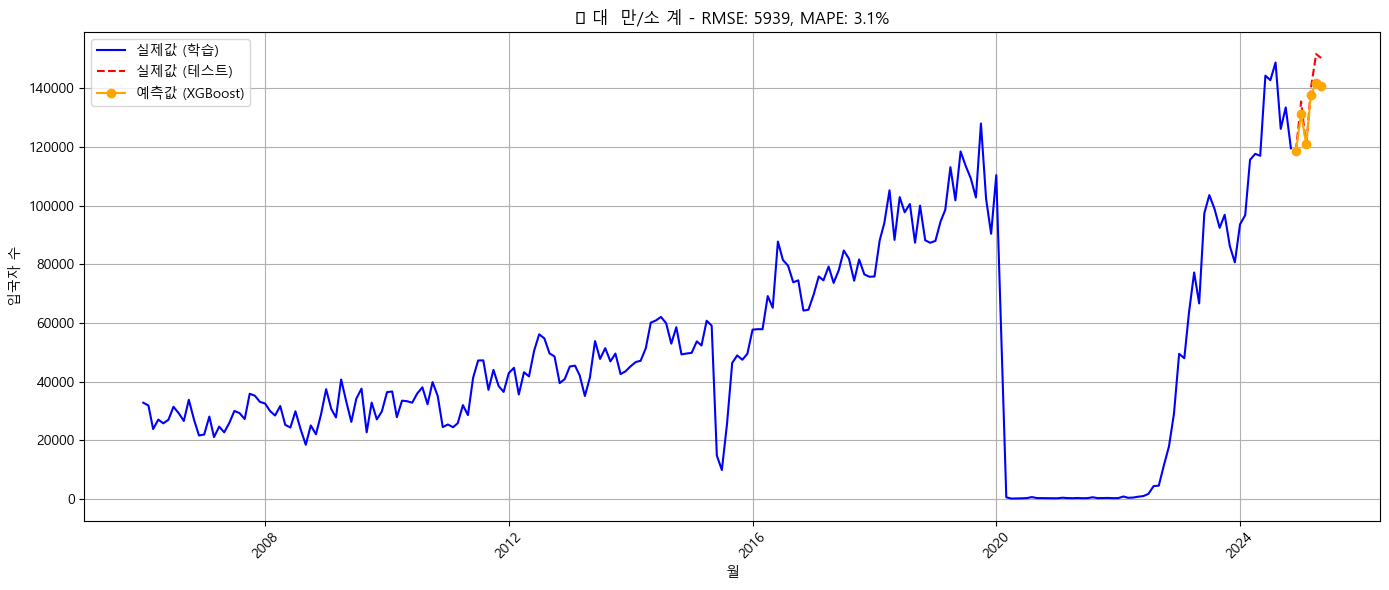

16:55:05 - cmdstanpy - INFO - Chain [1] start processing
16:55:05 - cmdstanpy - INFO - Chain [1] done processing


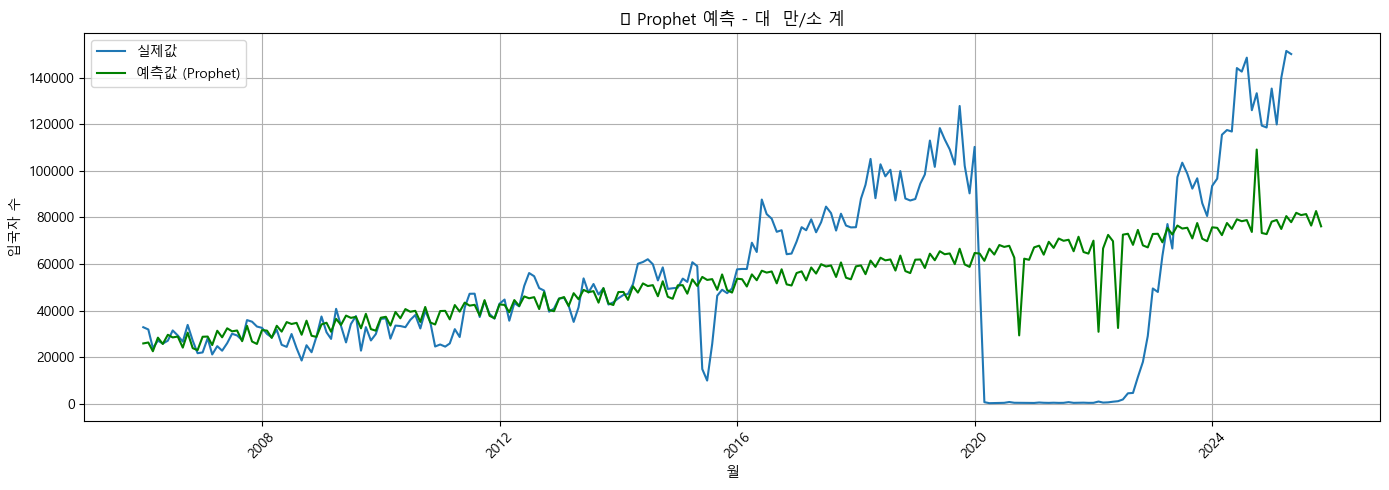


📌 예측 대상: 대  만 / 유학연수 (245 개월치)

📊 XGBoost 성능 평가
- RMSE: 55
- MAPE: 9.8%
- 평균 대비 RMSE 비율: 11.1%
✅ 매우 우수한 예측 (MAPE < 10%)
           월     실제값   예측값   오차  오차율(%)
239  2024-12   380.0   358  -21   -5.68
240  2025-01   227.0   210  -16   -7.17
241  2025-02  1139.0  1114  -24   -2.19
242  2025-03   529.0   455  -73  -13.90
243  2025-04   213.0   232   19    9.06
244  2025-05   499.0   393 -105  -21.05


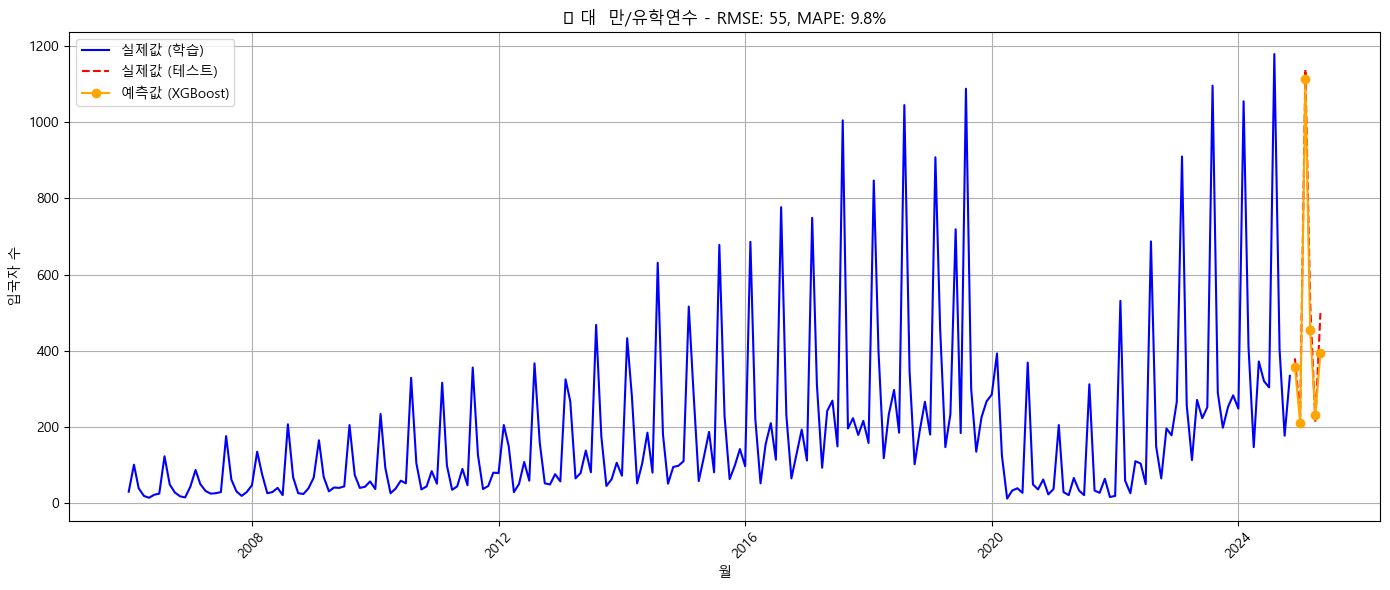

16:55:14 - cmdstanpy - INFO - Chain [1] start processing
16:55:15 - cmdstanpy - INFO - Chain [1] done processing


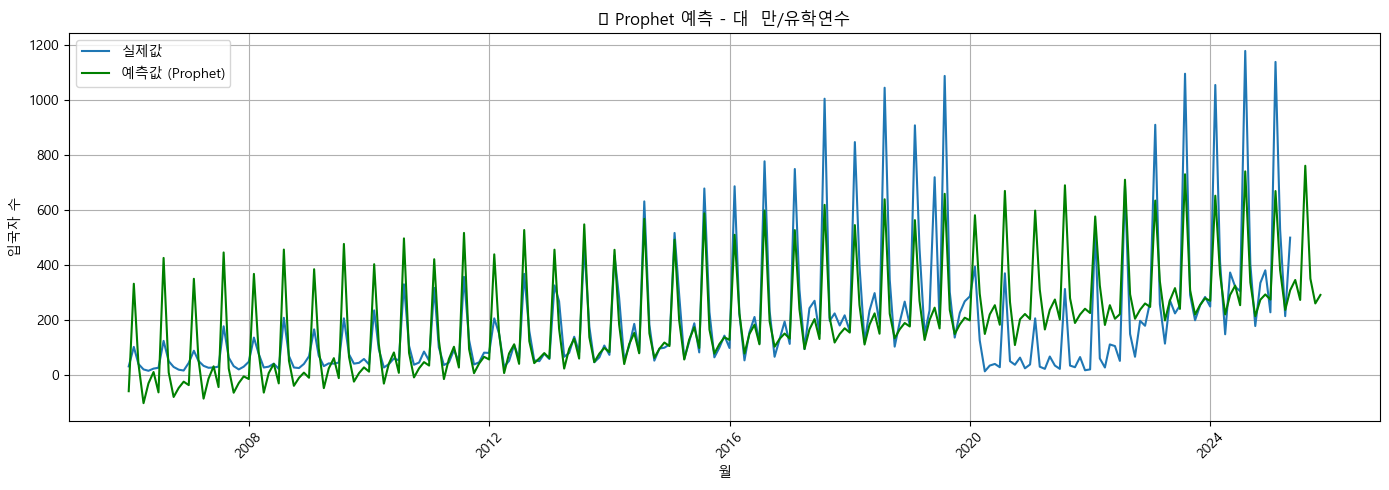

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

def normalize(text):
    return text.replace(" ", "").lower()

선택_국적 = input("예측할 국적 입력 (전체 예측 원하면 Enter): ").strip()
선택_목적 = input("예측할 목적 입력 (전체 예측 원하면 Enter): ").strip()

df = pd.read_csv('./proz/jang/data/목적별_국적별_입국_(05년1월~25년5월).csv', encoding='cp949')
if '구분' in df.columns:
    df = df[df['구분'] == '합계']
    df = df.drop(columns=['구분'])

df = df.melt(id_vars=['국적', '목적'], var_name='월', value_name='입국자수')
df['월'] = pd.to_datetime(df['월'], format='%Y년%m월', errors='coerce')
df = df.dropna(subset=['월'])
df['입국자수'] = pd.to_numeric(df['입국자수'].astype(str).str.replace(",", ""), errors='coerce')

if 선택_국적:
    match = [nat for nat in df["국적"].dropna().unique()
             if isinstance(nat, str) and normalize(선택_국적) in normalize(nat)]
    if match:
        선택_국적 = match[0]
        print(f"👉 입력한 국적과 유사한 값으로 '{선택_국적}' 사용")
    else:
        print("❌ 유효한 국적이 아닙니다."); 선택_국적 = ""

if 선택_목적:
    match = [pur for pur in df["목적"].dropna().unique()
             if isinstance(pur, str) and normalize(선택_목적) in normalize(pur)]
    if match:
        선택_목적 = match[0]
        print(f"👉 입력한 목적과 유사한 값으로 '{선택_목적}' 사용")
    else:
        print("❌ 유효한 목적이 아닙니다."); 선택_목적 = ""

targets = df.groupby(["국적", "목적"]).size().reset_index().rename(columns={0: "count"})
valid_targets = targets[targets['count'] > 24]
if 선택_국적:
    valid_targets = valid_targets[valid_targets["국적"] == 선택_국적]
if 선택_목적:
    valid_targets = valid_targets[valid_targets["목적"] == 선택_목적]

for idx, row in valid_targets.iterrows():
    국적, 목적 = row["국적"], row["목적"]
    df_filtered = df[(df["국적"] == 국적) & (df["목적"] == 목적)].sort_values("월").reset_index(drop=True)
    if len(df_filtered) < 30:
        continue

    print(f"\n📌 예측 대상: {국적} / {목적} ({len(df_filtered)} 개월치)")

    df_filtered["연도"] = df_filtered["월"].dt.year
    df_filtered["월_숫자"] = df_filtered["월"].dt.month
    df_filtered["계절"] = df_filtered["월"].dt.month % 12 // 3
    df_filtered["전월입국자수"] = df_filtered["입국자수"].shift(1)
    df_filtered["전년동월입국자수"] = df_filtered["입국자수"].shift(12)
    df_filtered["전월증감률"] = df_filtered["입국자수"].pct_change().shift(1)
    df_filtered["전년증감률"] = (df_filtered["입국자수"] - df_filtered["입국자수"].shift(12)) / df_filtered["입국자수"].shift(12)
    df_filtered["이동평균3"] = df_filtered["입국자수"].rolling(window=3).mean().shift(1)
    df_filtered["이동평균6"] = df_filtered["입국자수"].rolling(window=6).mean().shift(1)
    df_filtered["전월_차이"] = df_filtered["입국자수"] - df_filtered["전월입국자수"]
    df_filtered["전년_차이"] = df_filtered["입국자수"] - df_filtered["전년동월입국자수"]
    df_filtered["연중누적합"] = df_filtered.groupby("연도")["입국자수"].cumsum()
    df_filtered = df_filtered.replace([np.inf, -np.inf], np.nan).dropna().copy()
    if df_filtered.empty:
        continue

    features = ["연도", "월_숫자", "계절", "전월입국자수", "전년동월입국자수",
                "전월증감률", "전년증감률", "이동평균3", "이동평균6",
                "전월_차이", "전년_차이", "연중누적합"]
    X = df_filtered[features]
    y = df_filtered["입국자수"]
    dates = df_filtered["월"]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test = X_scaled[:-6], X_scaled[-6:]
    y_train, y_test = y[:-6], y[-6:]
    dates_train, dates_test = dates[:-6], dates[-6:]

    if len(X_test) == 0:
        continue

    xgb = XGBRegressor(random_state=42)
    param_dist = {
        'n_estimators': [100, 300, 500],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    }
    search = RandomizedSearchCV(xgb, param_distributions=param_dist, n_iter=10,
                                 cv=TimeSeriesSplit(n_splits=3),
                                 scoring='neg_root_mean_squared_error', random_state=42)
    search.fit(X_train, y_train)
    best_model = search.best_estimator_

    y_pred = np.clip(best_model.predict(X_test), 0, None)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100

    print(f"\n📊 XGBoost 성능 평가")
    print(f"- RMSE: {rmse:.0f}")
    print(f"- MAPE: {mape:.1f}%")
    rel_rmse = rmse / y_test.mean()
    print(f"- 평균 대비 RMSE 비율: {rel_rmse*100:.1f}%")
    if mape < 10:
        print("✅ 매우 우수한 예측 (MAPE < 10%)")
    elif mape < 20:
        print("✅ 양호한 예측 (MAPE < 20%)")
    elif mape < 30:
        print("⚠️ 보통 수준 예측 (MAPE < 30%)")
    else:
        print("❌ 예측 정확도 낮음 (MAPE > 30%)")

    result_df = pd.DataFrame({
        '월': dates_test.dt.strftime('%Y-%m'),
        '실제값': y_test.values,
        '예측값': y_pred.astype(int),
        '오차': (y_pred - y_test).astype(int),
        '오차율(%)': ((y_pred - y_test) / y_test * 100).round(2)
    })
    print(result_df)

    plt.figure(figsize=(14, 6))
    plt.plot(dates_train, y_train, label="실제값 (학습)", color='blue')
    plt.plot(dates_test, y_test, label="실제값 (테스트)", color='red', linestyle='--')
    plt.plot(dates_test, y_pred, label="예측값 (XGBoost)", color='orange', marker='o')
    plt.title(f"📊 {국적}/{목적} - RMSE: {rmse:.0f}, MAPE: {mape:.1f}%")
    plt.xlabel("월")
    plt.ylabel("입국자 수")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    df_prophet = df_filtered[["월", "입국자수"]].rename(columns={"월": "ds", "입국자수": "y"})
    prophet = Prophet(yearly_seasonality=True)
    try:
        prophet.add_country_holidays(country_name='KR')
        prophet.fit(df_prophet)
        future = prophet.make_future_dataframe(periods=6, freq='MS')
        forecast = prophet.predict(future)

        plt.figure(figsize=(14, 5))
        plt.plot(df_prophet['ds'], df_prophet['y'], label='실제값')
        plt.plot(forecast['ds'], forecast['yhat'], label='예측값 (Prophet)', color='green')
        plt.title(f"🔮 Prophet 예측 - {국적}/{목적}")
        plt.xlabel("월")
        plt.ylabel("입국자 수")
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"[Prophet 오류] {국적}/{목적}: {e}")


In [3]:
print(df.columns)

Index(['국적', '목적', '월', '입국자수'], dtype='object')


In [11]:
# 1. 이 코드는 보통 노트북의 가장 첫 부분, 단독 셀에 한 번만 실행합니다.
import pandas as pd

# 2. 이제 실제 데이터를 로드하는 코드입니다.
# '여기에_실제_데이터_파일_경로와_이름.csv' 부분을 당신의 실제 파일 경로와 이름으로 바꿔주세요!
# 예시: df = pd.read_csv('C:/Users/Admin/Desktop/your_data.csv')
# 또는 파일이 주피터 노트북 파일과 같은 폴더에 있다면: df = pd.read_csv('your_data.csv')

df = pd.read_csv('./proz/jang/data/목적별_국적별_입국_(05년1월~25년5월).csv', encoding='cp949')

print("데이터프레임이 실제 데이터로 로드되었습니다:")
print(df.head()) # 데이터의 첫 5줄을 확인하여 잘 로드되었는지 보세요.

# ---

# 3. 데이터 로드 후, 국가 목록을 확인하는 코드입니다.
if '국가' in df.columns:
    all_unique_countries = df['국가'].unique()

    print(f"\n데이터에 포함된 모든 국가의 총 개수: {len(all_unique_countries)}개")
    print("\n데이터에 포함된 모든 고유한 국가 목록:")
    for country in all_unique_countries:
        print(f"- {country}")
else:
    print("\n경고: '국가' 컬럼을 찾을 수 없습니다. 실제 데이터 파일에 나라 정보가 담긴 컬럼의 이름을 확인해주세요.")
    print("현재 데이터프레임의 컬럼 목록:", df.columns.tolist())

데이터프레임이 실제 데이터로 로드되었습니다:
     국적    목적 2005년01월 2005년02월 2005년03월 2005년04월 2005년05월 2005년06월 2005년07월  \
0   NaN   NaN    인원(명)    인원(명)    인원(명)    인원(명)    인원(명)    인원(명)    인원(명)   
1  아시아주    관광  267,308  300,056  323,044  275,212  251,608  248,988  272,441   
2  아시아주    상용   13,199   11,615   15,747   15,611   16,592   15,906   15,236   
3  아시아주    공용      402      282      445      424      542      614      463   
4  아시아주  유학연수    1,541    6,686    3,850    1,085      818    1,148    1,741   

  2005년08월  ... 2024년09월   2024년10월 2024년11월 2024년12월 2025년01월 2025년02월  \
0    인원(명)  ...    인원(명)      인원(명)    인원(명)    인원(명)    인원(명)    인원(명)   
1  301,526  ...  939,292  1,048,602  925,052  889,047  783,132  706,104   
2   17,084  ...    9,282      9,534    9,401    7,430    6,440    9,023   
3      527  ...    3,303      3,238    3,553    1,709    1,088    1,392   
4    6,459  ...   44,374     17,080   21,865   25,130   14,724   72,198   

    2025년03월   2025년04월   2025년05월         

In [12]:
import pandas as pd

# 이미 데이터프레임 'df'가 실제 데이터로 로드되어 있다고 가정합니다.
# (이전 셀에서 pd.read_csv(...)를 성공적으로 실행했다는 의미입니다.)

# 1. '국적' 컬럼에서 고유한 나라 목록 가져오기
# 컬럼 이름이 '국가'가 아닌 '국적'임을 확인했습니다.
unique_nationalities = df['국적'].unique()

# 2. 고유한 나라들의 개수 세기
num_nationalities = len(unique_nationalities)

# 결과 출력
print(f"데이터에 포함된 고유한 국가의 총 개수: {num_nationalities}개")
print("\n포함된 고유한 국가 목록:")
for nation in unique_nationalities:
    print(f"- {nation}")

데이터에 포함된 고유한 국가의 총 개수: 76개

포함된 고유한 국가 목록:
- nan
- 아시아주
- 일  본
- 인  도
- 베트남
- 미얀마
- 몽  골
- 스리랑카
- 파키스탄
- 방글라데시
- 중  국
- 대  만
- 필리핀
- 홍  콩
- 태  국
- 말레이시아
- 싱가포르
- 인도네시아
- 아시아주 기타
- 중 동
- 우즈베키스탄
- 터  키
- 이스라엘
- 이  란
- 카자흐스탄
- 요르단
- 사우디아라비아
- 이라크
- 중 동 기타
- 미 주
- 미  국
- 에콰도르
- 쿠  바
- 캐나다
- 브라질
- 멕시코
- 칠  레
- 아르헨티나
- 콜롬비아
- 페  루
- 베네수엘라
- 미 주 기타
- 구 주
- 러시아(연방)
- 폴란드
- 덴마크
- 그리스
- 스위스
- 노르웨이
- 스페인
- 루마니아
- 벨기에
- 독  일
- 영  국
- 프랑스
- 네덜란드
- 우크라이나
- 이탈리아
- 불가리아
- 스웨덴
- 구 주 기타
- 대양주
- 오스트레일리아
- 뉴질랜드
- 키리바시
- 피  지
- 대양주 기타
- 아프리카주
- 남아프리카 공화국
- 나이지리아
- 이집트
- 아프리카주 기타
- 기 타
- 교포
- 미상
- 전 체


In [13]:
df_cleaned = df.dropna(subset=['국적'])
# 이제 df_cleaned 데이터프레임에는 '국적' 컬럼에 nan이 포함된 행이 없습니다.
print(df_cleaned['국적'].unique())

['아시아주' '일  본' '인  도' '베트남' '미얀마' '몽  골' '스리랑카' '파키스탄' '방글라데시' '중  국'
 '대  만' '필리핀' '홍  콩' '태  국' '말레이시아' '싱가포르' '인도네시아' '아시아주 기타' '중 동'
 '우즈베키스탄' '터  키' '이스라엘' '이  란' '카자흐스탄' '요르단' '사우디아라비아' '이라크' '중 동 기타'
 '미 주' '미  국' '에콰도르' '쿠  바' '캐나다' '브라질' '멕시코' '칠  레' '아르헨티나' '콜롬비아' '페  루'
 '베네수엘라' '미 주 기타' '구 주' '러시아(연방)' '폴란드' '덴마크' '그리스' '스위스' '노르웨이' '스페인'
 '루마니아' '벨기에' '독  일' '영  국' '프랑스' '네덜란드' '우크라이나' '이탈리아' '불가리아' '스웨덴'
 '구 주 기타' '대양주' '오스트레일리아' '뉴질랜드' '키리바시' '피  지' '대양주 기타' '아프리카주'
 '남아프리카 공화국' '나이지리아' '이집트' '아프리카주 기타' '기 타' '교포' '미상' '전 체']


In [14]:
import pandas as pd
import numpy as np # nan 처리를 위해 numpy도 임포트합니다.

# df는 이미 로드되었다고 가정합니다.

# 1. '국적' 컬럼에 nan이거나 '아시아주', '미 주', '구 주', '대양주', '아프리카주', '기 타', '교포', '미상', '전 체'인 행 제거
# 실제 국가명만을 남기기 위함입니다.
exclude_list = ['아시아주', '미 주', '구 주', '대양주', '아프리카주', '기 타', '교포', '미상', '전 체']

# '국적'이 NaN이 아니고, exclude_list에 포함되지 않는 행만 필터링
df_filtered = df[df['국적'].notna() & ~df['국적'].isin(exclude_list)].copy()

# 2. '계.1' 컬럼을 숫자형으로 변환
# 쉼표(,)를 제거하고, 공백 제거 후 숫자형(float)으로 변환
# errors='coerce'는 변환 중 오류가 발생하면 해당 값을 NaN으로 만듭니다.
df_filtered['계.1'] = df_filtered['계.1'].astype(str).str.replace(',', '', regex=False).str.strip().replace('', np.nan).astype(float)

# '계.1' 컬럼에 NaN이 된 행도 제거 (데이터 변환 오류나 원본 NaN 등)
df_final = df_filtered.dropna(subset=['계.1']).copy()

# '국적' 컬럼에서 여전히 공백이 남아있을 수 있으므로 스트립 처리
df_final['국적'] = df_final['국적'].astype(str).str.strip()

print("--- 전처리 후 데이터프레임의 첫 5행 ---")
print(df_final.head())
print("\n--- 전처리 후 '국적' 컬럼의 고유 값 (일부) ---")
print(df_final['국적'].unique()[:10]) # 상위 10개만 확인

--- 전처리 후 데이터프레임의 첫 5행 ---
      국적    목적 2005년01월 2005년02월 2005년03월 2005년04월 2005년05월 2005년06월 2005년07월  \
7   일  본    관광  189,569  191,921  244,309  180,976  160,274  162,648  172,843   
8   일  본    상용    3,862    3,761    3,747    3,803    3,626    3,690    3,687   
9   일  본    공용      159      109      151      108      112      175       88   
10  일  본  유학연수      521      852      493      230      201      318      390   
11  일  본    기타    3,521    3,311    3,019    3,688    3,855    3,519    3,781   

   2005년08월  ... 2024년09월 2024년10월 2024년11월 2024년12월 2025년01월 2025년02월  \
7   206,261  ...  304,277  317,845  334,850  245,072  168,284  216,891   
8     4,038  ...    1,437    1,240    1,153    1,044    1,490    1,447   
9       109  ...      268      189      679      156      158      135   
10    1,006  ...    1,179      456      838      742    1,244    2,755   
11    5,086  ...    3,491    3,536    3,678    3,532    3,541    3,254   

   2025년03월 2025년04월 2025년05월         계.1

In [16]:
import pandas as pd
import numpy as np

# df는 이미 로드되었다고 가정합니다.
# (이전 셀에서 pd.read_csv(...)를 성공적으로 실행했다는 의미입니다.)

# 1. '목적' 컬럼에서 '관광', '상용', '공용', '유학연수', '기타'와 같은 값이 아닌 행만 필터링
# 즉, '목적' 컬럼에 NaN이 아닌 (진짜 목적이 있는) 행을 필터링하고,
# 그 중에서 '국적' 컬럼이 특정 분류(아시아주, 미주 등)에 속하지 않는 행을 선택합니다.
# 그리고 0번째 행처럼 '목적' 컬럼이 NaN인 경우는 제외합니다.
df_clean_purpose = df[df['목적'].notna()].copy()

# '목적' 컬럼이 '관광', '상용', '공용', '유학연수', '기타' 중 하나인 행만 선택하여 실제 국가 데이터를 포함한 행으로 간주
valid_purposes = ['관광', '상용', '공용', '유학연수', '기타']
df_filtered_by_purpose = df_clean_purpose[df_clean_purpose['목적'].isin(valid_purposes)].copy()

# '국적' 컬럼에 NaN 값과 대륙 분류 ('아시아주', '미 주' 등) 제거
# 이제 '목적' 컬럼으로 1차 필터링했으니, 여기서 다시 '국적'을 정제합니다.
exclude_list = ['아시아주', '미 주', '구 주', '대양주', '아프리카주', '기 타', '교포', '미상', '전 체']
df_final = df_filtered_by_purpose[df_filtered_by_purpose['국적'].notna() &
                                  ~df_filtered_by_purpose['국적'].isin(exclude_list)].copy()

# 2. '국적' 컬럼의 모든 공백 제거 (예: '일  본' -> '일본')
df_final['국적'] = df_final['국적'].astype(str).str.replace(' ', '', regex=False)

# 3. '계.1' 컬럼을 숫자형으로 변환 (쉼표 제거 및 오류 처리)
df_final['계.1'] = df_final['계.1'].astype(str).str.replace(',', '', regex=False).str.strip().replace('', np.nan).astype(float)

# '계.1' 컬럼에 NaN이 된 행도 제거 (데이터 변환 오류나 원본 NaN 등)
df_final.dropna(subset=['계.1'], inplace=True)


print("--- 전처리 후 데이터프레임의 첫 5행 (재확인) ---")
print(df_final.head())
print("\n--- 전처리 후 '국적' 컬럼의 고유 값 (일부 재확인) ---")
print(df_final['국적'].unique()[:10]) # 상위 10개만 확인


# 4. 입국자 수가 많은 순서대로 국가 정렬 및 출력

# '국적' 컬럼을 기준으로 그룹화하고, 각 국적별 '계.1' 값을 모두 더합니다.
country_entry_counts = df_final.groupby('국적')['계.1'].sum().sort_values(ascending=False)

# nan을 제거하고 정확하게 필터링된 총 국가 개수
total_unique_countries_cleaned = len(country_entry_counts)

print(f"\n--- 최종 정제된 고유 국가의 총 개수: {total_unique_countries_cleaned}개 ---")

if not country_entry_counts.empty:
    # 최초 입국을 많이 한 국적 출력
    top_country = country_entry_counts.index[0]
    top_entries = country_entry_counts.iloc[0]
    print(f"\n최초 입국을 가장 많이 한 국적: {top_country} ({int(top_entries):,d}명)")

    print("\n--- 입국을 많이 한 순서대로 국가 목록 (5개씩 한 줄) ---")

    count = 0
    line = []
    for country, total_entries in country_entry_counts.items():
        # 혹시 모를 비정상적인 값 필터링
        if not isinstance(country, str) or pd.isna(country) or country.strip() == '':
            continue

        line.append(f"{country} ({int(total_entries):,d}명)")
        count += 1
        if count % 5 == 0:
            print(" | ".join(line))
            line = []
    if line: # 남은 국가가 있다면 출력
        print(" | ".join(line))
else:
    print("\n정제 후 국가 데이터가 없습니다. 필터링 조건을 다시 확인해 주세요.")

--- 전처리 후 데이터프레임의 첫 5행 (재확인) ---
    국적    목적 2005년01월 2005년02월 2005년03월 2005년04월 2005년05월 2005년06월 2005년07월  \
7   일본    관광  189,569  191,921  244,309  180,976  160,274  162,648  172,843   
8   일본    상용    3,862    3,761    3,747    3,803    3,626    3,690    3,687   
9   일본    공용      159      109      151      108      112      175       88   
10  일본  유학연수      521      852      493      230      201      318      390   
11  일본    기타    3,521    3,311    3,019    3,688    3,855    3,519    3,781   

   2005년08월  ... 2024년09월 2024년10월 2024년11월 2024년12월 2025년01월 2025년02월  \
7   206,261  ...  304,277  317,845  334,850  245,072  168,284  216,891   
8     4,038  ...    1,437    1,240    1,153    1,044    1,490    1,447   
9       109  ...      268      189      679      156      158      135   
10    1,006  ...    1,179      456      838      742    1,244    2,755   
11    5,086  ...    3,491    3,536    3,678    3,532    3,541    3,254   

   2025년03월 2025년04월 2025년05월         계.1  
7  

In [17]:
import pandas as pd
import numpy as np

# df는 이미 로드되었다고 가정합니다.
# (이전 셀에서 pd.read_csv(...)를 성공적으로 실행했다는 의미입니다.)

# 1. 데이터 전처리: '목적' 컬럼을 활용하여 실제 국가 데이터만 필터링
df_clean_purpose = df[df['목적'].notna()].copy()

valid_purposes = ['관광', '상용', '공용', '유학연수', '기타']
df_filtered_by_purpose = df_clean_purpose[df_clean_purpose['목적'].isin(valid_purposes)].copy()

exclude_list = ['아시아주', '미 주', '구 주', '대양주', '아프리카주', '기 타', '교포', '미상', '전 체']
df_final = df_filtered_by_purpose[df_filtered_by_purpose['국적'].notna() &
                                  ~df_filtered_by_purpose['국적'].isin(exclude_list)].copy()

# 2. '국적' 컬럼의 모든 공백 제거 (예: '일  본' -> '일본')
df_final['국적'] = df_final['국적'].astype(str).str.replace(' ', '', regex=False)

# 3. '계.1' 컬럼을 숫자형으로 변환 (쉼표 제거 및 오류 처리)
df_final['계.1'] = df_final['계.1'].astype(str).str.replace(',', '', regex=False).str.strip().replace('', np.nan).astype(float)

# '계.1' 컬럼에 NaN이 된 행도 제거
df_final.dropna(subset=['계.1'], inplace=True)


# 4. 입국자 수가 많은 순서대로 국가 정렬 및 출력

# '국적' 컬럼을 기준으로 그룹화하고, 각 국적별 '계.1' 값을 모두 더합니다.
country_entry_counts = df_final.groupby('국적')['계.1'].sum().sort_values(ascending=False)

# 최종 정제된 고유 국가의 총 개수
total_unique_countries_cleaned = len(country_entry_counts)


# --- 최종 출력 ---
print(f"--- 최종 정제된 고유 국가의 총 개수: {total_unique_countries_cleaned}개 ---")

if not country_entry_counts.empty:
    # 최초 입국을 많이 한 국적 출력
    top_country = country_entry_counts.index[0]
    top_entries = country_entry_counts.iloc[0]
    print(f"\n최초 입국을 가장 많이 한 국적: {top_country} ({int(top_entries):,d}명)")

    print("\n--- 입국을 많이 한 순서대로 국가 목록 (5개씩 한 줄) ---")

    count = 0
    line = []
    for country, total_entries in country_entry_counts.items():
        # 혹시 모를 비정상적인 값 필터링
        if not isinstance(country, str) or pd.isna(country) or country.strip() == '':
            continue

        line.append(f"{country} ({int(total_entries):,d}명)")
        count += 1
        if count % 5 == 0:
            print(" | ".join(line))
            line = []
    if line: # 남은 국가가 있다면 출력
        print(" | ".join(line))
else:
    print("\n정제 후 국가 데이터가 없습니다. 필터링 조건을 다시 확인해 주세요.")

--- 최종 정제된 고유 국가의 총 개수: 66개 ---

최초 입국을 가장 많이 한 국적: 중국 (64,048,546명)

--- 입국을 많이 한 순서대로 국가 목록 (5개씩 한 줄) ---
중국 (64,048,546명) | 일본 (48,432,221명) | 미국 (15,171,191명) | 대만 (12,601,202명) | 홍콩 (7,485,480명)
필리핀 (7,173,390명) | 태국 (6,315,682명) | 베트남 (4,130,410명) | 말레이시아 (3,881,840명) | 러시아(연방) (3,593,627명)
싱가포르 (3,426,629명) | 인도네시아 (3,411,886명) | 캐나다 (2,831,018명) | 중동 (2,813,650명) | 오스트레일리아 (2,503,078명)
인도 (2,175,521명) | 영국 (2,098,036명) | 독일 (1,998,965명) | 프랑스 (1,606,953명) | 아시아주기타 (1,511,323명)
구주기타 (1,412,957명) | 몽골 (1,404,482명) | 미얀마 (1,244,333명) | 우즈베키스탄 (868,757명) | 이탈리아 (700,881명)
네덜란드 (594,954명) | 뉴질랜드 (548,711명) | 카자흐스탄 (486,890명) | 우크라이나 (481,479명) | 아프리카주기타 (453,835명)
터키 (426,847명) | 중동기타 (424,211명) | 스페인 (374,797명) | 폴란드 (335,790명) | 멕시코 (319,546명)
스리랑카 (311,279명) | 브라질 (305,244명) | 스웨덴 (293,251명) | 스위스 (255,147명) | 노르웨이 (248,950명)
방글라데시 (235,067명) | 이스라엘 (222,694명) | 루마니아 (211,554명) | 파키스탄 (209,938명) | 벨기에 (198,275명)
덴마크 (197,611명) | 남아프리카공화국 (191,783명) | 미주기타 (186,684명) | 사우디아라비아 (16